In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 200)

In [2]:
X_train_dataset = pd.read_csv("X.csv")
y_train_dataset = pd.read_csv("y.csv")
df = pd.merge(X_train_dataset, y_train_dataset, on=["engine_id", "flight_datetime", "flight_phase"])

In [3]:
df['engine_family'].unique()

array(['CFM56-5B', 'CF34-8E', 'CFM56-7'], dtype=object)

In [4]:
df['engine_type'].unique()

array(['CFM56-5B4', 'CF34-8E5', 'CFM56-7B27/B1', 'CFM56-7B26',
       'CFM56-5B3'], dtype=object)

### Mechanical problems

#### CFM56-2/-3/-5A/-5B/-7 Theoretical Parameter Shifts

Problem names:

- p1: **VSV closed $2^\circ$**

- p2: **VSV open $2^\circ$**

- p3: **VBV open $10^\circ$**

- p4: **+1%W25 9th stg customer bleed (leakage)**

- p5: **+1%W25 5th stg customer bleed (leakage)**

- p6: **+1%W25 5th stg bleed (LPT Cooling, HPTACC)**

- p7: **+1%W25 9th stg bleed (CDP/4T Seals, HPTACC)**

- p8: **-0.5%W13 decrease (Dirty Fan blades)**

- p9: **-1pt FAN efficiency**

- p10: **-1pt Booster efficiency**

- p11: **-1pt HPC efficiency**

- p12: **-1pt HPT efficiency**

- p13: **-1pt LPT efficiency**

Parameters used:

- DEGT: EGT deviation from baseline
- GWFM: Fuel flow deviation from baseline
- GPCN25: Core speed deviation from baseline


In [5]:
mechanical_problem = {
    'p1': [(0.0, 4.0), (0.0, 0.3), (0.0, 1.0)],
    'p2': [(-1.0, 0.0), (0.0, 0.0), (-1.2, 0.0)],
    'p3': [(0.0, 11.0), (0.0, 1.0), (0.0, 0.1)],
    'p4': [(0.0, 10.0), (0.0, 1.3), (0.0, 0.2)],
    'p5': [(0.0, 9.0), (0.0, 0.8), (0.0, 0.2)],
    'p6': [(0.0, 2.0), (0.0, 0.2), (-0.4, 0.0)],
    'p7': [(0.0, 6.0), (0.0, 0.5), (-0.8, 0.0)],
    'p8': [(-10.0, 0.0), (-2.0, 0.0), (-0.9, 0.0)],
    'p9': [(0.0, 6.0), (0.0, 1.3), (0.0, 0.7)],
    'p10': [(0.0, 4.0), (0.0, 0.4), (0.0, 0.1)],
    'p11': [(0.0, 6.0), (0.0, 0.6), (-0.8, 0.0)],
    'p12': [(0.0, 8.0), (0.0, 0.8), (-1.0, 0.0)],
    'p13': [(0.0, 8.0), (0.0, 1.7), (0.0, 0.8)],
}

full_names = {
    'p1': 'VSV closed 2',
    'p2': 'VSV open 2',
    'p3': 'VBV open 10',
    'p4': '+1%W25 9th stg customer bleed (leakage)',
    'p5': '+1%W25 5th stg customer bleed (leakage)',
    'p6': '+1%W25 5th stg bleed (LPT Cooling, HPTACC)',
    'p7': '+1%W25 9th stg bleed (CDP/4T Seals, HPTACC)',
    'p8': '-0.5%W13 decrease (Dirty Fan blades)',
    'p9': '-1pt FAN efficiency',
    'p10': '-1pt Booster efficiency',
    'p11': '-1pt HPC efficiency',
    'p12': '-1pt HPT efficiency',
    'p13': '-1pt LPT efficiency'
}

In [7]:
def check_condition(data: pd.DataFrame, intervals: list):
    """
    Функция выполняет проверку трех условий для параметров из DataFrame.

    Параметры:
        - data (pd.DataFrame): DataFrame, на основе которого будет выполняться проверка.
        - intervals (list): Список интервалов, содержащий значения верхней и нижней границ для каждого из параметров.

    Возвращает:
        - list: Список индексов строк, удовлетворяющих условиям.

    """
    problem = data.copy()
    for param, interval in zip(["DEGT", "GWFM", "GPCN25"], intervals):
        problem = problem[(problem[param] >= interval[0]) & (problem[param] <= interval[1])]
    return list(problem.index)

def check_problem(target_engine_id: str, target_aircraft_id: str, df: pd.DataFrame, mechanical_problem: dict):
    """
    Функция проверяет выполнение условий проблем для заданного двигателя и воздушного судна.

    Параметры:
        - target_engine_id (str): Идентификатор целевого двигателя.
        - target_aircraft_id (str): Идентификатор целевого воздушного судна.
        - df (pd.DataFrame): DataFrame, содержащий данные о двигателях и воздушных судах.
        - mechanical_problem (dict): Словарь, содержащий проблемы и соответствующие им интервалы значений параметров.

    Возвращает:
        - dict: Словарь, где ключи соответствуют проблемам, а значения - спискам индексов строк, удовлетворяющих условиям.

    """
    target_data = df.loc[(df['engine_id'] == target_engine_id) & (df['aircraft_id'] == target_aircraft_id)].sort_values('flight_datetime')
    results = {p: [] for p in mechanical_problem.keys()}
    
    for problem, intervals in mechanical_problem.items():
        results[problem].extend(check_condition(target_data, intervals))
    return results

def find_all_mech_problem(df: pd.DataFrame, mechanical_problem: dict):
    """
    Функция находит все механические проблемы в DataFrame для всех уникальных пар двигатель-воздушное судно.

    Параметры:
        - df (pd.DataFrame): DataFrame, содержащий данные о двигателях, воздушных судах и их параметрах.
        - mechanical_problem (dict): Словарь, содержащий проблемы и соответствующие им интервалы значений параметров.

    Возвращает:
        - pd.DataFrame: DataFrame с результатами, содержащими идентификаторы двигателя и воздушного судна, параметры, проблемы и соответствующие индексы строк.

    """
    unique_pairs = df[['engine_id', 'aircraft_id']].drop_duplicates()
    
    results = {
        'engine_id': [],
        'aircraft_id': [],
        'DEGT': [],
        'GWFM': [],
        'GPCN25': [],
        'engine_family': [],
        'engine_type': [],
        'problem_name': [],
        'main_id': []
    }
    
    for engine_id, aircraft_id in zip(unique_pairs['engine_id'], unique_pairs['aircraft_id']):
        current = check_problem(engine_id, aircraft_id, df, mechanical_problem)
        for problem in current.keys():
            for ind in current[problem]:
                results['engine_id'].append(engine_id)
                results['aircraft_id'].append(aircraft_id)
                results['DEGT'].append(df.iloc[ind]['DEGT'])
                results['GWFM'].append(df.iloc[ind]['GWFM'])
                results['GPCN25'].append(df.iloc[ind]['GPCN25'])
                results['engine_family'].append(df.iloc[ind]['engine_family'])
                results['engine_type'].append(df.iloc[ind]['engine_type'])
                results['problem_name'].append(full_names[problem])
                results['main_id'].append(ind)  
    return pd.DataFrame(results)

In [8]:
problem = find_all_mech_problem(df, mechanical_problem)

In [9]:
problem

,engine_id,aircraft_id,DEGT,GWFM,GPCN25,engine_family,engine_type,problem_name,main_id
0,6dc714d821a73d97c06143281b622c4e45c791985425c8...,31baf613cc66c483d5576812d060e54d64275325be437f...,4.137451,1.009322,0.170869,CF34-8E,CF34-8E5,+1%W25 9th stg customer bleed (leakage),48365
1,6dc714d821a73d97c06143281b622c4e45c791985425c8...,31baf613cc66c483d5576812d060e54d64275325be437f...,4.137451,1.009322,0.170869,CF34-8E,CF34-8E5,-1pt FAN efficiency,48365
2,6dc714d821a73d97c06143281b622c4e45c791985425c8...,31baf613cc66c483d5576812d060e54d64275325be437f...,4.137451,1.009322,0.170869,CF34-8E,CF34-8E5,-1pt LPT efficiency,48365
3,17347326abdfbcd8acc523a9069dba5f770f1f65ca9b21...,ac5a9ee6985da1ed0780c817d7ac0cc5ec571d9c55f56c...,3.963135,0.620057,0.042544,CF34-8E,CF34-8E5,VBV open 10,20026
4,17347326abdfbcd8acc523a9069dba5f770f1f65ca9b21...,ac5a9ee6985da1ed0780c817d7ac0cc5ec571d9c55f56c...,4.475220,0.797171,0.137855,CF34-8E,CF34-8E5,+1%W25 9th stg customer bleed (leakage),49984
...,...,...,...,...,...,...,...,...,...
2472,9a124d266cba9143ef7685c7bc99c07b48aaa8f1822f02...,467295d533d5ee94a8265c44774fe307ad915b29096dda...,7.771362,1.444780,0.133863,CF34-8E,CF34-8E5,-1pt LPT efficiency,74898
2473,9a124d266cba9143ef7685c7bc99c07b48aaa8f1822f02...,467295d533d5ee94a8265c44774fe307ad915b29096dda...,7.822510,0.643202,0.134754,CF34-8E,CF34-8E5,-1pt LPT efficiency,1546
2474,9a124d266cba9143ef7685c7bc99c07b48aaa8f1822f02...,467295d533d5ee94a8265c44774fe307ad915b29096dda...,5.024658,0.546888,0.023792,CF34-8E,CF34-8E5,-1pt LPT efficiency,14313
2475,9a124d266cba9143ef7685c7bc99c07b48aaa8f1822f02...,467295d533d5ee94a8265c44774fe307ad915b29096dda...,7.539673,0.435916,0.105499,CF34-8E,CF34-8E5,-1pt LPT efficiency,22710


### Распределение проблем

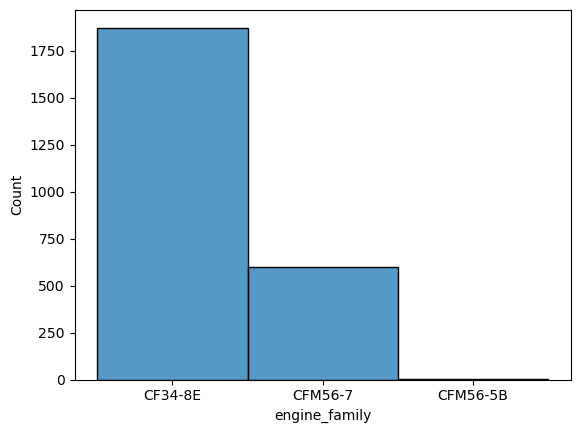

In [11]:
sns.histplot(problem["engine_family"])
plt.show()

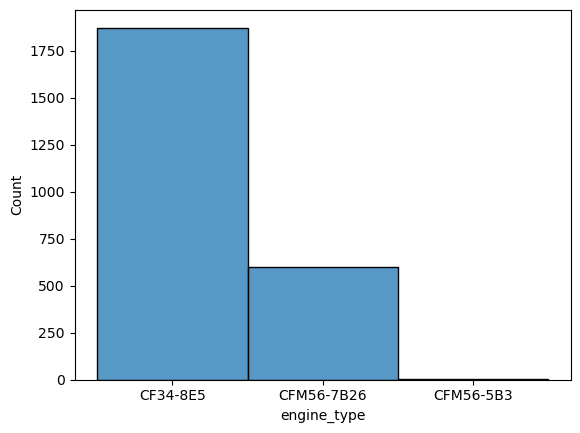

In [12]:
sns.histplot(problem["engine_type"])
plt.show()